In [2]:
######LIBRARIES##################
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


1. Plot the dataset noisy sin sample.csv

In [3]:
df = pd.read_csv("/home/colton_baker/msds/Spring 2025/Deep Learning/HW/HW2/noisy_sin_samples.csv", names=["X", "sin(X) + eps"])

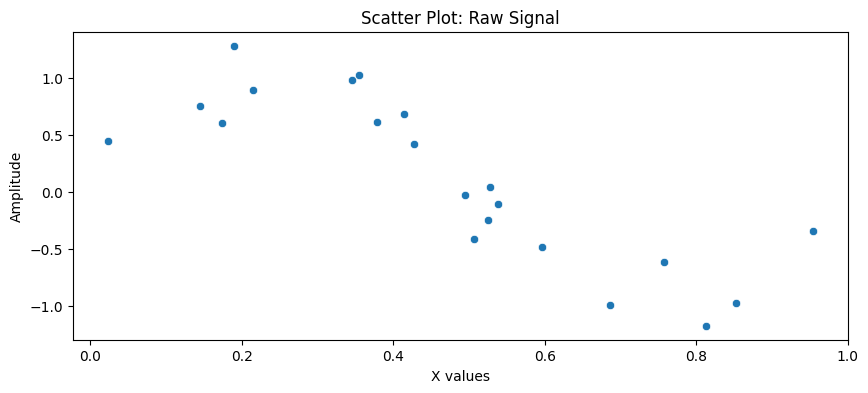

In [4]:
#scatter plot
plt.figure(figsize=(10,4))
sns.scatterplot(data=df, x="X", y="sin(X) + eps")
plt.xlabel("X values")
plt.ylabel("Amplitude")
plt.title("Scatter Plot: Raw Signal")
plt.show()

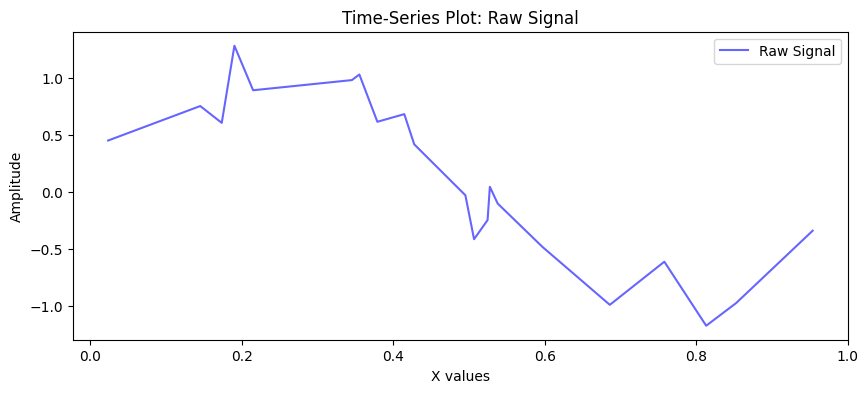

In [5]:
# time-series
plt.figure(figsize=(10,4))
sns.lineplot(data=df, x="X", y="sin(X) + eps", label="Raw Signal", color="blue", alpha=0.6)
plt.xlabel("X values")
plt.ylabel("Amplitude")
plt.title("Time-Series Plot: Raw Signal")
plt.legend()
plt.show()

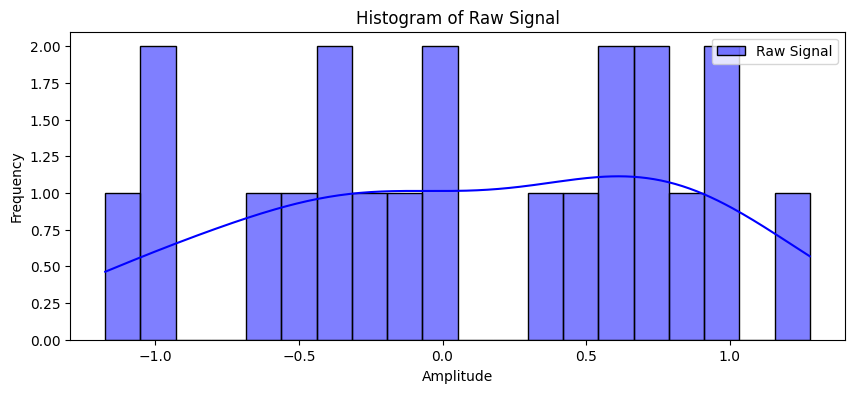

In [6]:

# histogram
plt.figure(figsize=(10,4))
sns.histplot(df["sin(X) + eps"], bins=20, kde=True, color="blue", label="Raw Signal", alpha=0.5)
plt.xlabel("Amplitude")
plt.ylabel("Frequency")
plt.title("Histogram of Raw Signal")
plt.legend()
plt.show()

2. Design three MLPs with 1 hidden layer and ReLU activation function for non-linear
regression using 50, 90 and 130 neurons in the hidden layer. For each architecture, train
a nonlinear regression model for varying numbers of epochs, and analyze the result
calculating the accuracy (MSE error).

In [7]:
# converting to numpy arrays
X = df["X"].values.reshape(-1, 1)
y = df['sin(X) + eps'].values.reshape(-1, 1)

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # is 42 a ref to Hitchhiker's Guide?

# transform to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).reshape(-1, 1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)


In [8]:
# nonlinear regression model
class NonLinearRegression(nn.Module):
    def __init__(self, hidden_layers, activation_func):
        super(NonLinearRegression, self).__init__()
        self.fc1 = nn.Linear(1, hidden_layers) # input to hidden layer
        self.activation_func =  activation_func# activation function i.e. ReLU = max(0, x-c) or tanh(x)
        self.fc2 = nn.Linear(hidden_layers,1) # hidden layer to one cont. ouput (regression)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.activation_func(out) # applying activation
        out = self.fc2(out) # activated hidden to output
        return out # output


In [9]:
# function definition for model trainer
def train_model(hidden_layers, activation_func, num_epochs=1000, learning_rate=0.01):
    model = NonLinearRegression(hidden_layers, activation_func)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # storage container for comparison
    train_losses = []
    best_epoch = 0
    best_loss = float("inf")
    for epoch in range(num_epochs):
        # set the model to training mode
        model.train()
        # clear gradient after each step so grads don't sum up 
        optimizer.zero_grad()
        # training data into model phi(x)
        outputs = model(X_train_tensor)
        # sum_1^{n}(y-yhat)^2
        loss = criterion(outputs, y_train_tensor) 
        # compute grads for backprop
        loss.backward()
         # update weights
        optimizer.step()
        # track the training losses to store in container
        train_losses.append(loss.item())

        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = epoch +1

    # evaluate the model
    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train_tensor).numpy()
        y_pred_test = model(X_test_tensor).numpy()
        
    #compute the mse from training and testing
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)

    torch.save(model.state_dict(), f"model_{hidden_layers}_{activation_func.__class__.__name__}.pth")
    return model, train_losses, train_mse, test_mse, best_epoch

3. Repeat the analysis, keeping the best epoch number found above using this time the Tanh
activation function.
Plot the regression results (superimposed to the original dataset as in the regression
example shown in class) for the two activation functions and provide observations on the
performance of each activation function, i.e., compare accuracy.


Training ReLU model with 50 neurons...

Training Tanh model with 50 neurons (Best ReLU Epoch: 998)...

Training ReLU model with 90 neurons...

Training Tanh model with 90 neurons (Best ReLU Epoch: 1000)...

Training ReLU model with 130 neurons...

Training Tanh model with 130 neurons (Best ReLU Epoch: 987)...


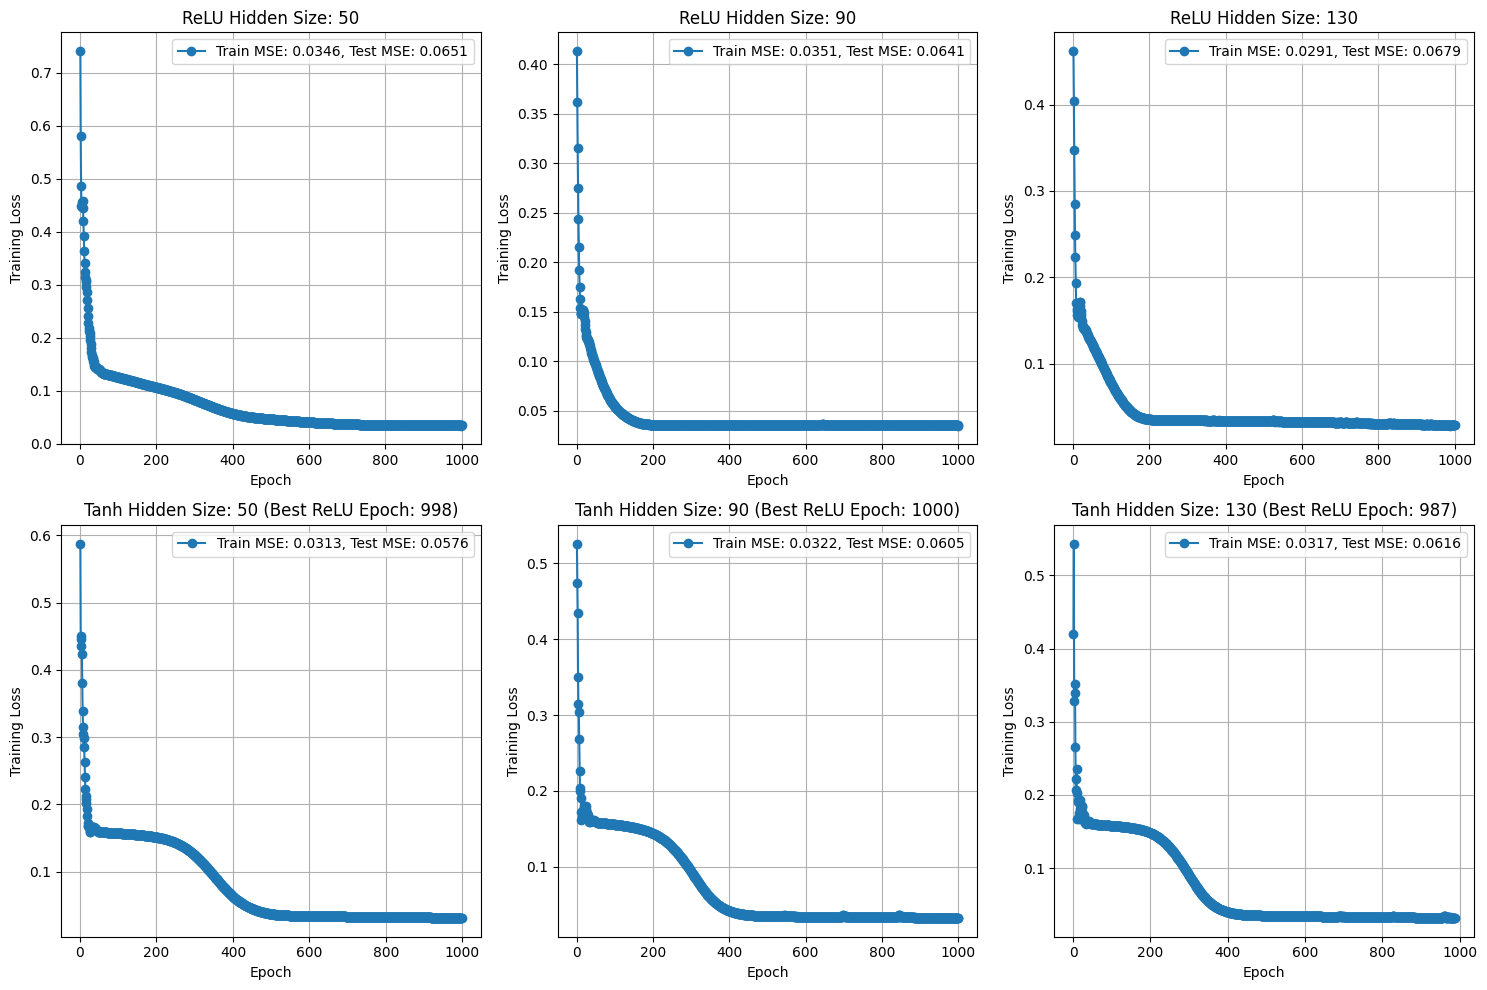

In [10]:
# trainging model with different hidden layer sizes
hidden_layers = [50, 90, 130]
mse_results = {}
fig, axs = plt.subplots(2, len(hidden_layers), figsize=(15, 10))

for i, hidden_size in enumerate(hidden_layers):
    print(f"\nTraining ReLU model with {hidden_size} neurons...")
    relu_model, relu_train_losses, relu_train_mse, relu_test_mse, best_epoch = train_model(hidden_size, nn.ReLU())

    print(f"\nTraining Tanh model with {hidden_size} neurons (Best ReLU Epoch: {best_epoch})...")
    tanh_model, tanh_train_losses, tanh_train_mse, tanh_test_mse, _ = train_model(hidden_size, nn.Tanh(), num_epochs=best_epoch)

    mse_results[hidden_size] = {
        "ReLU": {"Train MSE": relu_train_mse, "Test MSE": relu_test_mse},
        "Tanh": {"Train MSE": tanh_train_mse, "Test MSE": tanh_test_mse}
    }

    ax_relu = axs[0, i]  # First row for ReLU
    ax_tanh = axs[1, i]  # Second row for Tanh

    ax_relu.plot(range(1, len(relu_train_losses) + 1), relu_train_losses, marker='o', 
                 label=f'Train MSE: {relu_train_mse:.4f}, Test MSE: {relu_test_mse:.4f}')
    ax_relu.set_xlabel('Epoch')
    ax_relu.set_ylabel('Training Loss')
    ax_relu.set_title(f'ReLU Hidden Size: {hidden_size}')
    ax_relu.legend()
    ax_relu.grid(True)

    ax_tanh.plot(range(1, len(tanh_train_losses) + 1), tanh_train_losses, marker='o', 
                 label=f'Train MSE: {tanh_train_mse:.4f}, Test MSE: {tanh_test_mse:.4f}')
    ax_tanh.set_xlabel('Epoch')
    ax_tanh.set_ylabel('Training Loss')
    ax_tanh.set_title(f'Tanh Hidden Size: {hidden_size} (Best ReLU Epoch: {best_epoch})')
    ax_tanh.legend()
    ax_tanh.grid(True)

plt.tight_layout()
plt.show()


/tmp/ipykernel_126445/4083131215.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  relu_model.load_state_dict(torch.load(f"model_{size}_ReLU.pth"))
/tmp/ipykernel_126445/

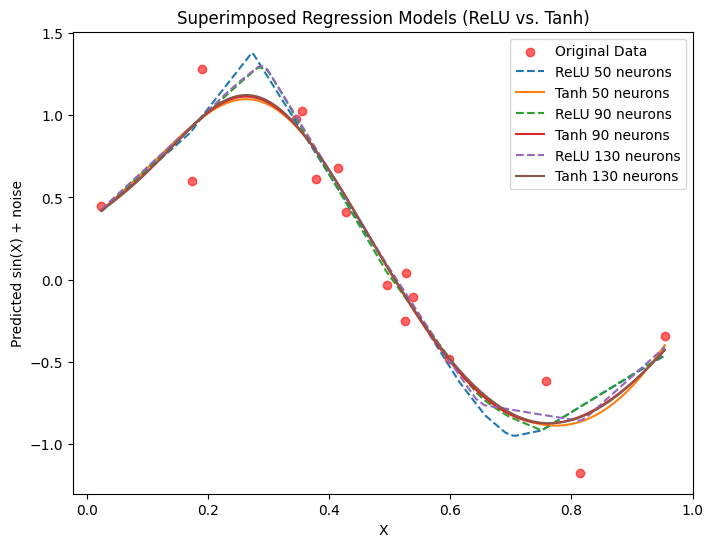

In [14]:
# Generate smooth X values for plotting
X_plot = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
X_plot_tensor = torch.tensor(X_plot, dtype=torch.float32)

plt.figure(figsize=(8, 6))
plt.scatter(X_train, y_train, color='red', alpha=0.6, label='Original Data')

for size in hidden_layers:
    relu_model = NonLinearRegression(size, nn.ReLU())
    relu_model.load_state_dict(torch.load(f"model_{size}_ReLU.pth"))
    relu_model.eval()
    with torch.no_grad():
        y_relu_pred = relu_model(X_plot_tensor).numpy()
    plt.plot(X_plot, y_relu_pred, linestyle="dashed", label=f"ReLU {size} neurons")
    
    tanh_model = NonLinearRegression(size, nn.Tanh())
    tanh_model.load_state_dict(torch.load(f"model_{size}_Tanh.pth"))
    tanh_model.eval()
    with torch.no_grad():
        y_tanh_pred = tanh_model(X_plot_tensor).numpy()
    plt.plot(X_plot, y_tanh_pred, label=f"Tanh {size} neurons")

plt.xlabel("X")
plt.ylabel("Predicted sin(X) + noise")
plt.title("Superimposed Regression Models (ReLU vs. Tanh)")
plt.legend()
plt.show()


**Comparison of Models:**

ReLU: The ReLU with 90 neurons seemed to perform best out of the other ReLU models. The train MSE and test MSE were balanced. It also seemd to converge at an optimal rate over the other too. It was the best fit out of the three.

Tanh: The Tanh with 50 neurons seems to have performed the best out of the group. It had a well balanced MSE. All Tanh models did seem to overfit the data. This is likely due to the nature og the Tanh function in comparison to the sine function. 

Overall the ReLU with 90 neurons is the most balanced model.